In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Find the bounds of the data and inputs
first = session.query(measurement.date).order_by(measurement.date).first()
last = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"""First date: {first[0]} 
Last Date: {last[0]}""")

First date: 2010-01-01 
Last Date: 2017-08-23


In [11]:
#inspect data formats
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
select = [measurement.date, measurement.prcp]   
data_one_year = session.query(*select).\
    filter(measurement.date >= "2016-08-23").all()


In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
dates = [result[0] for result in data_one_year]
prcp = [result[1] for result in data_one_year]
prcpdata_df = pd.DataFrame({"Date" : dates ,"precipitation": prcp})
prcpdata_df["Date"]=pd.to_datetime(prcpdata_df["Date"])
prcpdata_df=prcpdata_df.sort_values(by=["Date"]).fillna(0)
prcpdata_df = prcpdata_df.set_index("Date")


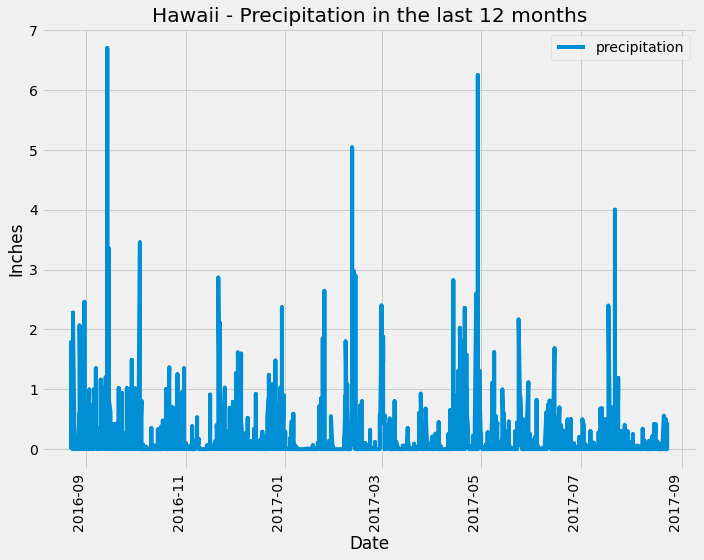

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpdata_df.plot(rot = 90, figsize = (10,8))
plt.title("Hawaii - Precipitation in the last 12 months")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdata_df.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(measurement).group_by(measurement.station).count()
print(f" There are {stations} stations")

 There are 9 stations


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [measurement.station, 
       func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

mostactive = session.query(*sel).\
    filter(measurement.station == "USC00519281").\
    group_by(measurement.station).all()
mostactive 

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
mosttemps = session.query(measurement.station, func.count(measurement.tobs)).\
group_by(measurement.station).\
order_by(func.count(measurement.tobs).desc()).all()
mosttemps

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
select = [measurement.date, measurement.tobs]   
data_one_year_temp = session.query(*select).\
    filter(measurement.station == "USC00519281").\
    filter(measurement.date >= "2016-08-23").all()

In [21]:
#sort data
dates = [result[0] for result in data_one_year_temp]
temp = [result[1] for result in data_one_year_temp]
tempdata_df = pd.DataFrame({"Date" : dates ,"tobs": temp})
tempdata_df["Date"]=pd.to_datetime(tempdata_df["Date"])
tempdata_df=tempdata_df.sort_values(by=["Date"]).fillna(0)
tempdata_df = tempdata_df.set_index("Date")


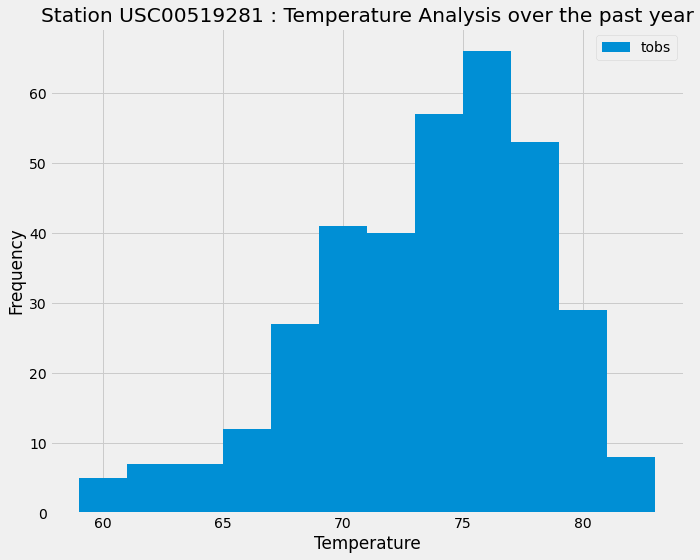

In [22]:
#histogram
plt.figure(figsize = (10,8))
plt.hist(tempdata_df["tobs"], bins = 12, label = "tobs")
plt.title("Station USC00519281 : Temperature Analysis over the past year")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()